In [1]:
# auto-reload all helper files
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import config
import numpy as np
from data import get_cifar10_data
from model import build_model
from train import compile_model, train_model, evaluate_model
from metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
x_train, y_train, x_test, y_test = get_cifar10_data()

In [4]:
# Build and compile - # Run ONCE per model lifecycle as it resets model weights

model = build_model()
model = compile_model(model)

In [5]:
# Train model

history = train_model(
    model,
    x_train,
    y_train,
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
)

print(">>> TRAINING STARTING <<<")

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 166s 231ms/step - accuracy: 0.2782 - loss: 1.9678 - val_accuracy: 0.2688 - val_loss: 2.3827 - learning_rate: 0.0500
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 163s 232ms/step - accuracy: 0.3901 - loss: 1.6776 - val_accuracy: 0.4246 - val_loss: 1.6362 - learning_rate: 0.0500
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 167s 237ms/step - accuracy: 0.4787 - loss: 1.4589 - val_accuracy: 0.4468 - val_loss: 1.8171 - learning_rate: 0.0500
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 162s 230ms/step - accuracy: 0.5469 - loss: 1.2987 - val_accuracy: 0.5540 - val_loss: 1.3611 - learning_rate: 0.0500
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 161s 229ms/step - accuracy: 0.5946 - loss: 1.1717 - val_accuracy: 0.6338 - val_loss: 1.0671 - learning_rate: 0.0500
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 161s 229ms/step - accuracy: 0.6323 - loss: 1.0656 - val_accuracy: 0.6358 - val_loss: 1.0777 - learning_rate: 0.0500
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 163s 231ms/step -

In [6]:
# Evaluate Testing Data

test_loss, test_accuracy = evaluate_model(model, x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss:.4f}")

Test accuracy: 86.52%
Test Loss: 0.4123


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


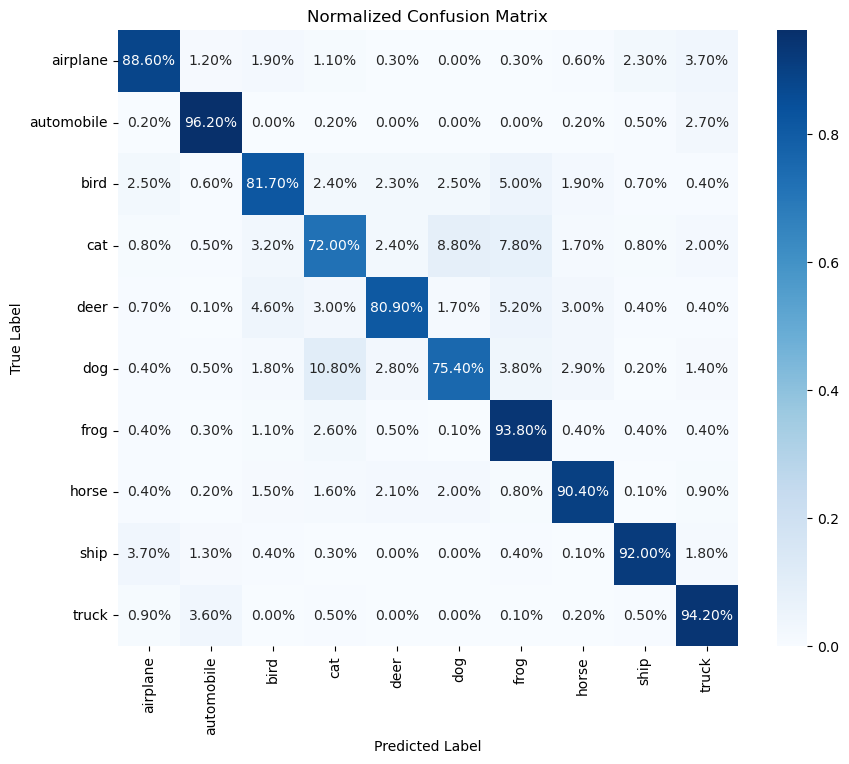

In [7]:
# Metrics

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred, config.NUM_CLASSES)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# notmalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm,annot=True, fmt=".2%", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()


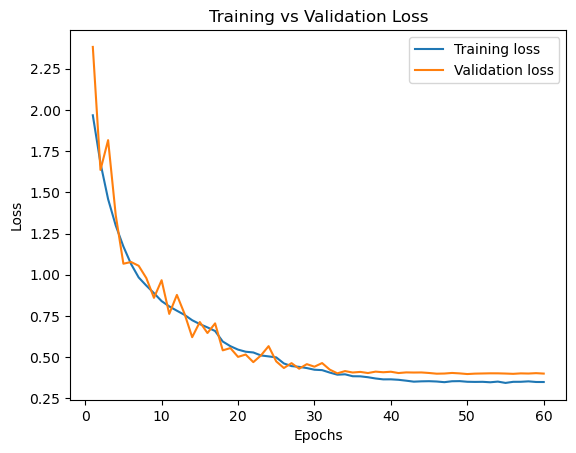

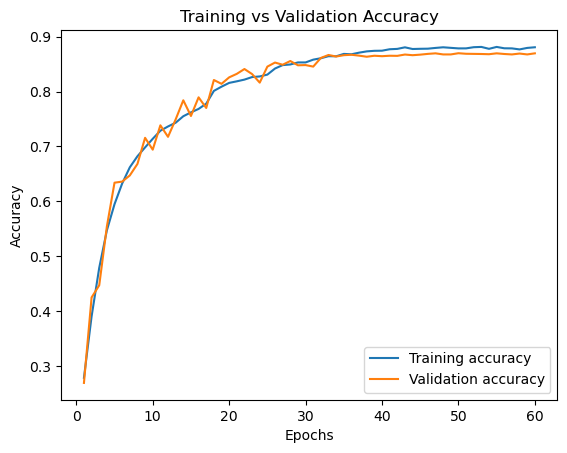

Training Loss: 0.349320
Validation Loss: 0.400453
Training Accuracy: 88.07%
Validation Accuracy: 86.96%


Best Epoch: 50
Best Training Loss: 0.3508
Best Validation Loss: 0.3977
Best Training Accuracy: 87.86%
Best Validation Accuracy: 86.98%


In [8]:
# Plot Training Data
val_loss = history.history['val_loss']
loss = history.history['loss']
# Cleaner and more explicit than hardcoding a range - becomes useful when EarlyStopping comes into play (we pass 'loss' but it could be any history.history.keys() as they all have same length)
epoch_axis = range(1, len(history.history["loss"]) + 1)

plt.figure()
plt.plot(epoch_axis, loss, label="Training loss")
plt.plot(epoch_axis, val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# storing accuracy metrics
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(epoch_axis, accuracy, label="Training accuracy")
plt.plot(epoch_axis, val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


# print last epoch training data results to snapshot the current model performance [tracked in Excel file]
print(f'Training Loss: {loss[-1]:4f}')
print(f'Validation Loss: {val_loss[-1]:4f}')
print(f'Training Accuracy: {accuracy[-1]:.2%}')
print(f'Validation Accuracy: {val_accuracy[-1]:.2%}')
print('\n')

# Print out the best epoch where val_loss was at a minimum
best_epoch = np.argmin(val_loss)

# Results below are diagnostics only (not used for Excel reporting)
print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Training Loss: {loss[best_epoch]:.4f}")
print(f"Best Validation Loss: {val_loss[best_epoch]:.4f}")
print(f"Best Training Accuracy: {accuracy[best_epoch]:.2%}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch]:.2%}")
